In [1]:
import os, sys, subprocess, time
import numpy as np
import matplotlib as mpl
import cv2 as cv
import winsound as ws
from midiutil import MIDIFile
from skimage import measure as meas, feature as feat
from matplotlib import pyplot as plt
from IPython import display as disp
from peakutils import peak
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [19]:
jtplot.reset()
# mpl.use('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/1.5, 9/1.5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [20]:
def otsu(image):
    image = (image/image.max() * 255).astype('uint8')
    hist = np.squeeze(cv.calcHist([image], [0], None, [256], [0, 255]))
    total = image.size
    top = 256
    sumB = 0
    wB = 0
    maximum = 0.0
    sum1 = np.arange(top) @ hist
    for i in range(top):
        wF = total - wB
        if wB > 0 and wF > 0:
            mF = (sum1 - sumB) / wF
            val = wB * wF * ((sumB/wB) - mF)**2
            if val >= maximum:
                level = i
                maximum = val
        wB += hist[i]
        sumB += i * hist[i]
    return level

def line_contrast(page_image):
    line_contr =[]
    for line in page_image: #determine range per line
        line_contr.append(max(line) - min(line))
    return line_contr

def find_rows(line_contr):
    """
    [1] van Gent, Paul. (2017). Deep learning music with Python. A techh blog about
        fun things with Python and embedded electronics. Retrieved from
        http://www.paulvangent.com/2017/12/07/deep-learning-music/.
    """
    detected_rows = []
    row_start = 0
    row_end = 0
    detect_state = 0 #0 if previous line was not part of a row
    cur_row = 0
    for contrast in line_contr:
        if contrast < 50 and detect_state == 0:
            row_start = cur_row
        elif contrast >= 50 and detect_state == 0:
            row_start = cur_row
            detect_state = 1
        elif contrast < 50 and detect_state == 1: #if end of row, evaluate AOI height
            row_end = cur_row
            rowheight = row_start - row_end
            if abs(rowheight) >= 150:
                detected_rows.append((row_start, row_end))
            detect_state = 0
        elif contrast >= 50 and detect_state == 1:
            pass
        else:
            print("unknown situation, help!, detection state: " + str(detect_state))
        cur_row += 1
    return detected_rows

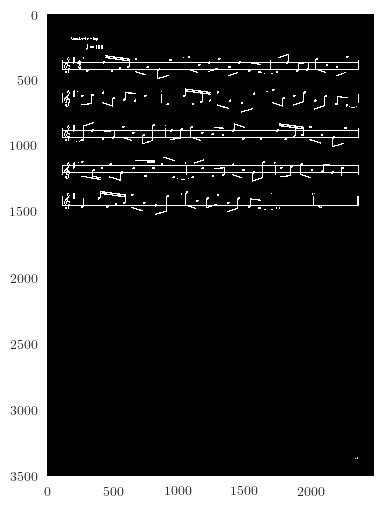

In [21]:
anc = cv.imread('anchors#1.png', 0)
anc = (anc < otsu(anc)).astype('uint8') * 255
im_h, im_w = anc.shape
plt.imshow(anc, 'gray')
plt.grid(0)
plt.show()

In [5]:
line_contr = line_contrast(anc)
detected_rows = find_rows(line_contr)

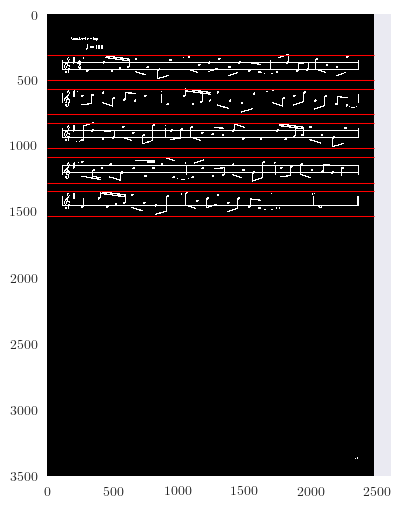

In [6]:
plt.imshow(anc, 'gray')
plt.hlines(np.ravel(detected_rows), 0, anc.shape[1], 'r', lw=0.75)
plt.grid(0)
plt.show()

In [11]:
staffs = [anc[i[0]:i[1]] for i in detected_rows]

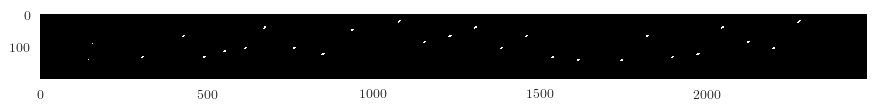

In [193]:
rect = cv.getStructuringElement(cv.MORPH_RECT, (1, 3))
disk = cv.getStructuringElement(cv.MORPH_ELLIPSE, (13, 13))
no_lines = cv.morphologyEx(staffs[0], cv.MORPH_OPEN, rect)
A = cv.erode(no_lines, disk)
plt.imshow(A, 'gray')
plt.grid(0)
cv.imwrite('anc_notebodies.png', A)
plt.show()

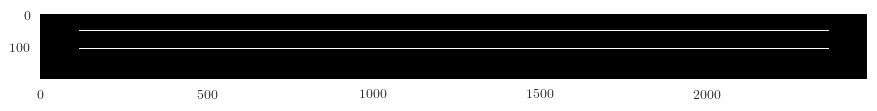

In [138]:
rect = cv.getStructuringElement(cv.MORPH_RECT, (160, 1))
staff_lines = cv.morphologyEx(staffs[0], cv.MORPH_OPEN, rect)
staffpos = np.unique(np.where(staff_lines == 255)[0])

plt.imshow(staff_lines, 'gray')
plt.grid(0)
plt.show()

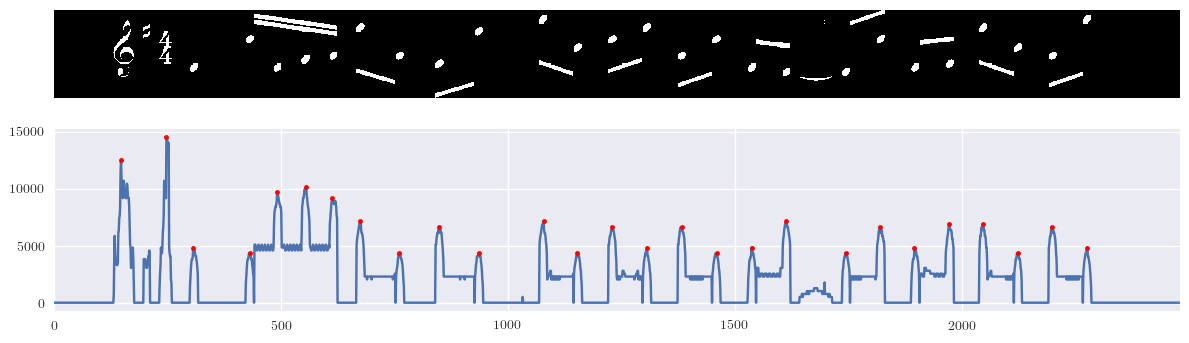

In [182]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(211)
ab = cv.erode(no_lines, cv.getStructuringElement(cv.MORPH_RECT, (5, 1)))
ax.imshow(ab, 'gray')
ax.axis('off')

ax = fig.add_subplot(212)
pk = peak.indexes(ab.sum(axis=0).astype(int), thres=0.25, min_dist=50)
ax.plot(ab.sum(axis=0))
ax.plot(np.arange(ab.shape[1])[pk], ab.sum(axis=0)[pk], 'r.')
ax.set_xlim(0, no_lines.shape[1])

plt.tight_layout()
plt.show()

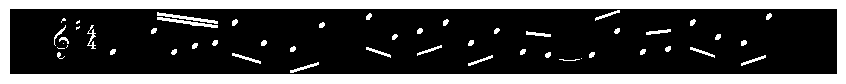

In [190]:
ab = cv.erode(no_lines, cv.getStructuringElement(cv.MORPH_RECT, (5, 1)))
plt.imshow(ab, 'gray')
plt.axis('off')
# cv.imwrite('anc_cutstem.png', ab)
plt.show()

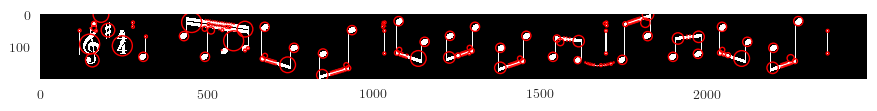

In [184]:
blobs = feat.blob_doh(A)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(A, 'gray')
for blob in blobs:
    y, x, r = blob.T
    c = plt.Circle((x, y), r, color='r', lw=1, fill=False)
    ax.add_patch(c)
plt.grid(0)
plt.show()

In [131]:
bloby, blobx, blob_radius = blobs.T
blob_area = np.round(np.pi * blob_radius**2).astype('uint8')

In [97]:
notethresh = np.mean(np.diff(staffpos))/2
home = staffpos[0] - notethresh/2
spacing = np.arange(home, home + notethresh*12, notethresh)